# IST 718: Big Data Analytics

- Professor: Daniel Acuna <deacuna@syr.edu>

## General instructions:

- You are welcome to discuss the problems with your classmates but __you are not allowed to copy any part of your answers either from your classmates or from the internet__
- You can put the homework files anywhere you want in your http://notebook.acuna.io workspace but _do not change_ the file names. The TAs and the professor use these names to grade your homework.
- Remove or comment out code that contains `raise NotImplementedError`. This is mainly to make the `assert` statement fail if nothing is submitted.
- The tests shown in some cells (i.e., `assert` and `np.testing.` statements) are used to grade your answers. **However, the professor and TAs will use __additional__ test for your answer. Think about cases where your code should run even if it passess all the tests you see.**
- Before downloading and submitting your work through Blackboard, remember to save and press `Validate` (or go to 
`Kernel`$\rightarrow$`Restart and Run All`). 
- Good luck!

In [1]:
# Load the packages needed for this part
# create spark and sparkcontext objects
from pyspark.sql import SparkSession
import numpy as np

spark = SparkSession.builder.getOrCreate()
sc = spark.sparkContext

import pyspark
from pyspark.ml import feature, regression, Pipeline
from pyspark.sql import functions as fn, Row
from pyspark import sql

import matplotlib.pyplot as plt
import pandas as pd

# Part 1: Servo analysis

In this assignment, you will continue the analysis we started in class of the Servo dataset.

# Servo data analysis

```console
1. Title: Servo Data

2. Sources
   (a) Created by: Karl Ulrich (MIT) in 1986
   (b) Donor: Ross Quinlan
   (c) Date: May 1993

3. Past Usage:

   1.  Quinlan, J.R., "Learning with continuous classes", Proc. 5th Australian
       Joint Conference on AI (eds A. Adams and L. Sterling), Singapore: World
       Scientific, 1992
 
   2.  Quinlan, J.R., "Combining instance-based and model-based learning",
       Proc. ML'93 (ed P.E. Utgoff), San Mateo: Morgan Kaufmann 1993
 
       Results on 10-way cross-validation:
 
       Method			Average		Relative
       ------			 |Err|		 Error
 				-------		--------
 
       Guessing mean		  1.15		  1.00
       Instance-based		   .52		   .26
       Regression		   .86		   .49
       Model trees		   .45		   .29
       Neural nets (G. Hinton)	   .30		   .11
       Regression+instances	   .48		   .20
       Model trees+instances	   .30		   .17
       NN+instances		   .29		   .11
 
4. Relevant Information:

   Ross Quinlan:

   This data was given to me by Karl Ulrich at MIT in 1986.  I didn't 
   record his description at the time, but here's his subsequent (1992) 
   recollection:
 
     "I seem to remember that the data was from a simulation of a servo
     system involving a servo amplifier, a motor, a lead screw/nut, and a
     sliding carriage of some sort.  It may have been on of the
     translational axes of a robot on the 9th floor of the AI lab.  In any
     case, the output value is almost certainly a rise time, or the time
     required for the system to respond to a step change in a position set
     point."
 
   (Quinlan, ML'93)

   "This is an interesting collection of data provided by Karl 
    Ulrich.  It covers an extremely non-linear phenomenon - predicting the 
    rise time of a servomechanism in terms of two (continuous) gain settings
    and two (discrete) choices of mechanical linkages."

5. Number of Instances: 167

6. Number of Attributes: 4 + numeric class attribute

7. Attribute information:

   1. motor: A,B,C,D,E
   2. screw: A,B,C,D,E
   3. pgain: 3,4,5,6
   4. vgain: 1,2,3,4,5
   5. class: 0.13 to 7.10

8. Missing Attribute Values: None
```

In [2]:
# Load the data
servo_df = spark.createDataFrame(pd.read_csv('/datasets/servo.data', 
            sep=',', 
            header=None,
            names=['motor', 'screw', 'pgain', 'vgain', 'rise_time']))

In [5]:
servo_df.show()

+-----+-----+-----+-----+------------------+
|motor|screw|pgain|vgain|         rise_time|
+-----+-----+-----+-----+------------------+
|    E|    E|    5|    4|        0.28125095|
|    B|    D|    6|    5|         0.5062525|
|    D|    D|    4|    3|        0.35625148|
|    B|    A|    3|    2|          5.500033|
|    D|    B|    6|    5|        0.35625148|
|    E|    C|    4|    3|0.8062545999999999|
|    C|    A|    3|    2|          5.100014|
|    A|    A|    3|    2|5.7000421999999995|
|    C|    A|    6|    5|        0.76875436|
|    D|    A|    4|    1|         1.0312537|
|    B|    E|    6|    5|        0.46875226|
|    E|    C|    5|    4|        0.39375174|
|    B|    C|    4|    1|        0.28125095|
|    E|    C|    3|    1|               1.1|
|    C|    C|    5|    4|         0.5062525|
|    E|    B|    3|    2|1.8999897000000001|
|    D|    C|    3|    1|         0.9000011|
|    B|    C|    5|    4|        0.46875226|
|    B|    B|    5|    4|         0.5437528|
|    C|   

# 1. Explore the data

With big data, datasets can be too big to bring them into the Spark client. However, we can use the `limit` method of a dataframe to limit the number of rows to bring as a Pandas dataframe

Create a dataframe `servo_sample_df` with the first 20 rows of `servo_df`

In [3]:
# create `servo_sample_df`
# YOUR CODE HERE
servo_sample_df=servo_df.limit(20)
#raise NotImplementedError()

In [4]:
# 2 pts - right number of rows
np.testing.assert_equal(servo_sample_df.count(), 20)

**(3 pts)** Below, transform `servo_sample_df` into a Pandas dataframe and do a scatter plot of `pgain` vs `rise_time`

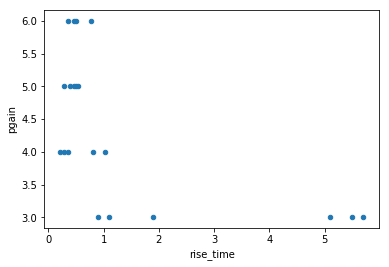

In [5]:
# YOUR CODE HERE
servo_sample_df=servo_sample_df.toPandas()
servo_sample_df.plot(kind='scatter', y='pgain', x='rise_time')
#raise NotImplementedError()

**(3 pts)** Below, transform `servo_sample_df` into a Pandas dataframe and do a scatter plot of `vgain` vs `rise_time`

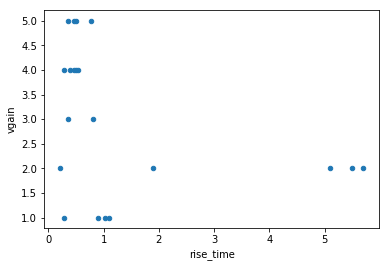

In [6]:
# YOUR CODE HERE
servo_sample_df.plot(kind='scatter', y='vgain', x='rise_time')
#raise NotImplementedError()

## Perform correlations between vgain-rise time, pgain-rise time, and vgain-pgain

Create a `servo_corr_df` dataframe that contains the correlations between `vgain` and `rise_time` as a column `corr_vgain_rise_time`, between `pgain` and `rise_time` as `corr_pgain_rise_time`, and `vgain` and `pgain` as `corr_vgain_pgain`.

In [7]:
# create `servo_corr_df` here
# YOUR CODE HERE
c1=servo_df.corr("vgain",'rise_time')
c2=servo_df.corr("pgain",'rise_time')
c3=servo_df.corr("vgain",'pgain')
mydf=sc.parallelize([(c1,c2,c3)])
servo_corr_df = mydf.toDF(["corr_vgain_rise_time","corr_pgain_rise_time","corr_vgain_pgain"])
#raise NotImplementedError()

In [8]:
## 7 pts
np.testing.assert_equal(set(servo_corr_df.columns), 
                        {'corr_pgain_rise_time', 'corr_vgain_pgain', 'corr_vgain_rise_time'})
np.testing.assert_almost_equal(list(servo_corr_df.first().asDict().values()),
                               [-0.36438266626914595, -0.5981287119612234, 0.8122683058183874], decimal=3)

## Compute mean rise_time for different motors and screws

Create `motor_rise_time_df` with the column `motor` and `avg_rise_time`, where `avg_rise_time` is the average rise time for a motor. Sort the resulting dataframe from highest to lowest average rise time.

In [9]:
# YOUR CODE HERE
motor_rise_time_df=servo_df.groupBy('motor').mean('rise_time').sort('avg(rise_time)',ascending=False).select('motor',fn.col("avg(rise_time)").alias('avg_rise_time'))
#raise NotImplementedError()

In [10]:
# 3 pts
np.testing.assert_array_almost_equal(
    (motor_rise_time_df.orderBy('motor').select('avg_rise_time').\
     rdd.map(lambda x: list(x.asDict().values())).collect())
    ,
[[1.761110668888889],
 [1.6819423677777776],
 [1.2540610067499998],
 [0.9176125145454546],
 [1.144893208181818]], decimal=3)

Create `screw_rise_time_df` with the column `screw` and `avg_rise_time` sorted from highest to lowest average rise time.

In [11]:
# YOUR CODE HERE
screw_rise_time_df=servo_df.groupBy('screw').mean('rise_time').sort('avg(rise_time)',ascending=False).select('screw',fn.col("avg(rise_time)").alias('avg_rise_time'))
#raise NotImplementedError()

In [12]:
# 3 pts
np.testing.assert_array_almost_equal(
    (screw_rise_time_df.orderBy('screw').select('avg_rise_time').\
     rdd.map(lambda x: list(x.asDict().values())).collect())
    ,
       [[1.768461212142857],
 [1.3919625091428571],
 [1.2485862280645161],
 [1.1612471173333332],
 [1.225643291724138]],
decimal=3)

# Feature engineering

## Dummy variables for motors and screws
Create a dataframe `dummy_df` with columns `motor` and `screw` as dummy variables, and columns `vgain`, `pgain`, and `rise_time`. Use motor D and screw C as the baselines and name the dummy variables `motor_A` for motor `A` and so on. Follow a similar pattern for screw. The dataframe `dummy_df` should not contain the columns `motor` and `screw` but only their dummy variable representations. **All column types should be float or integer.**

In [13]:
# create dummy_df below
# YOUR CODE HERE
my_df = servo_df.withColumn('motor_A', (fn.col('motor') == "A").cast("int"))
my_df = my_df.withColumn('motor_B', (fn.col('motor') == "B").cast("int"))
my_df = my_df.withColumn('motor_C', (fn.col('motor') == "C").cast("int"))
my_df = my_df.withColumn('motor_D', (fn.col('motor') == "D").cast("int"))
my_df = my_df.withColumn('motor_E', (fn.col('motor') == "E").cast("int"))
my_df = my_df.withColumn('screw_A', (fn.col('screw') == "A").cast("int"))
my_df = my_df.withColumn('screw_B', (fn.col('screw') == "B").cast("int"))
my_df = my_df.withColumn('screw_C', (fn.col('screw') == "C").cast("int"))
my_df = my_df.withColumn('screw_D', (fn.col('screw') == "D").cast("int"))
my_df = my_df.withColumn('screw_E', (fn.col('screw') == "E").cast("int"))

dummy_df = my_df.select("motor_A","motor_B","motor_C", "motor_E", "screw_A","screw_B","screw_D","screw_E", "vgain", "pgain", "rise_time")

#raise NotImplementedError()

In [14]:
# 3 pts
np.testing.assert_equal(len(dummy_df.columns), 11)
np.testing.assert_equal(dummy_df.select(fn.sum('motor_A')).first()['sum(motor_A)'], 36)
np.testing.assert_equal(dummy_df.select(fn.sum('screw_A')).first()['sum(screw_A)'], 42)

# Model comparison

In the next set of questions, you will use the splits below to fit, validate, and estimate the generalization error of your models. The `randomSplit` is called with a seed so that it does not change from what the professor used.

In [15]:
training_df, validation_df, testing_df = dummy_df.randomSplit([0.6, 0.3, 0.1], seed=0)
print("# points in training: ", training_df.count())
print("# points in validation: ", validation_df.count())
print("# points in testing: ", testing_df.count())

# points in training:  102
# points in validation:  50
# points in testing:  15


## Propose three regression models

In the next section, you will choose the best model to explain the data in `servo_df`. Select the right split of the data for the right step of the process (i.e., training, validation, and testing)

### Model 1: Fit model with only `pgain`

Create a pipeline that takes *pgain* as a feature to predict *rise time* and fits a linear regression model. You should start your pipeline by taking the appropriate column or columns from `dummy_df` in which the raw feature `pgain` may or may not have been feature engineered. Assign the fit pipeline transformer to `pipe_model1`. Your pipeline must have one vector assembler followed by a linear regression.

In [16]:
training_df

DataFrame[motor_A: int, motor_B: int, motor_C: int, motor_E: int, screw_A: int, screw_B: int, screw_D: int, screw_E: int, vgain: bigint, pgain: bigint, rise_time: double]

In [17]:
# create `pipe_model1` below
# YOUR CODE HERE
model0 = Pipeline(stages=[feature.VectorAssembler(inputCols=['pgain'],
                                        outputCol='features'),
                 regression.LinearRegression(labelCol='rise_time', featuresCol='features')])

pipe_model1=model0.fit(training_df)
#raise NotImplementedError()

In [18]:
# (5 pts)
np.testing.assert_equal(type(pipe_model1.stages[0]), feature.VectorAssembler)
np.testing.assert_equal(type(pipe_model1.stages[1]), regression.LinearRegressionModel)
np.testing.assert_array_equal(pipe_model1.stages[1].coefficients.shape, (1,))

### Model 2: Fit model with only `vgain`

Follow the same idea as above and create a pipeline transformer `pipe_model2`

In [19]:
# YOUR CODE HERE
model1 = Pipeline(stages=[feature.VectorAssembler(inputCols=['vgain'],
                                        outputCol='features'),
                 regression.LinearRegression(labelCol='rise_time', featuresCol='features')])

pipe_model2=model1.fit(training_df)
#raise NotImplementedError()

In [20]:
# (5 pts)
np.testing.assert_equal(type(pipe_model2.stages[0]), feature.VectorAssembler)
np.testing.assert_equal(type(pipe_model2.stages[1]), regression.LinearRegressionModel)
np.testing.assert_array_equal(pipe_model2.stages[1].coefficients.shape, (1,))

### Model 3: Fit model with only motor, screw, pgain, and vgain

Follow the same idea as above and create a pipeline transformer `pipe_model3`. Remember that some features have been feature engineered. In particular, use the transformed columns in the order: motor, screw, pgain, and vgain. Choose the columns from `dummy_df` appropriately.

In [21]:
# create `pipe_model2` below
# YOUR CODE HERE
model2 = Pipeline(stages=[feature.VectorAssembler(inputCols=['motor_A','motor_B','motor_C',
                                                             'motor_E','screw_A','screw_B','screw_D','screw_E',
                                                             'pgain','vgain'],
                                        outputCol='features'),
                 regression.LinearRegression(labelCol='rise_time', featuresCol='features')])

pipe_model3=model2.fit(training_df)

#raise NotImplementedError()

In [22]:
# (5 pts)
np.testing.assert_equal(type(pipe_model3.stages[0]), feature.VectorAssembler)
np.testing.assert_equal(type(pipe_model3.stages[1]), regression.LinearRegressionModel)
np.testing.assert_array_equal(pipe_model3.stages[1].coefficients.shape, (10,))

# Compare models

### Estimate RMSE on validation data for the three models

Create three dataframes `rmse1_df`, `rmse2_df`, and `rmse3_df` for models 1, 2, and 3, respectively, with only with column `rmse`

In [23]:

# create rmse1_df, rmse2_df, and rmse3_df dataframes below
# YOUR CODE HERE
predictions1 = pipe_model1.transform(validation_df)
rmse1 = predictions1.agg(fn.sqrt(fn.mean((fn.col('rise_time') - fn.col('prediction'))**2)).alias('rmse')).collect()
rmse1_df = spark.createDataFrame(rmse1)

predictions2 = pipe_model2.transform(validation_df)
rmse2 = predictions2.agg(fn.sqrt(fn.mean((fn.col('rise_time') - fn.col('prediction'))**2)).alias('rmse')).collect()
rmse2_df = spark.createDataFrame(rmse2)

predictions3 = pipe_model3.transform(validation_df)
rmse3 = predictions3.agg(fn.sqrt(fn.mean((fn.col('rise_time') - fn.col('prediction'))**2)).alias('rmse')).collect()
rmse3_df = spark.createDataFrame(rmse3)
#raise NotImplementedError()


In [24]:
# display the answers here
rmse1_df.show()
rmse2_df.show()
rmse3_df.show()

+------------------+
|              rmse|
+------------------+
|1.3415478760688782|
+------------------+

+-----------------+
|             rmse|
+-----------------+
|1.570575737299741|
+-----------------+

+------------------+
|              rmse|
+------------------+
|1.0876211260262372|
+------------------+



In [25]:
# (5 pts)
np.testing.assert_equal(rmse1_df.count(), 1)
np.testing.assert_equal(rmse2_df.count(), 1)
np.testing.assert_equal(rmse3_df.count(), 1)
np.testing.assert_equal(rmse1_df.columns, ['rmse'])
np.testing.assert_equal(rmse2_df.columns, ['rmse'])
np.testing.assert_equal(rmse3_df.columns, ['rmse'])

Assign the best cross validated model to a variable `best_model` below

In [26]:
# assign best model (the best pipeline transformer) to a variable best_model below
# YOUR CODE HERE
best_model=pipe_model3
#raise NotImplementedError()

In [27]:
# (2 pts)
np.testing.assert_equal(type(best_model), pyspark.ml.pipeline.PipelineModel)

### Estimate generalization performance with RMSE

Create a variable `rmse_best_df` that contains the RMSE of the best model on testing data

In [28]:
# create rmse_best_df
# YOUR CODE HERE
predictions_best = best_model.transform(testing_df)
rmse_best_df = predictions_best.agg(fn.sqrt(fn.mean((fn.col('rise_time') - fn.col('prediction'))**2)).alias('rmse')).collect()
rmse_best_df = spark.createDataFrame(rmse_best_df)
#raise NotImplementedError()

In [29]:
# (3 pts)
np.testing.assert_equal(rmse_best_df.count(), 1)
np.testing.assert_equal(rmse_best_df.columns, ['rmse'])

**(3 pts)** What is the best estimated generalization performance of the best model? Answer in the cell below

In [30]:
# YOUR CODE HERE
rmse_best_df.show()
#raise NotImplementedError()

+------------------+
|              rmse|
+------------------+
|1.7465890313061603|
+------------------+



# Do inference with best model

Assume that model 3 is the best one. Redefine a new pipeline for this model called `pipe_model_best` and fit it to the **entire training data** (all of `dummy_df`).

In [31]:
# create `pipe_model_best` below
# YOUR CODE HERE
model_best= Pipeline(stages=[feature.VectorAssembler(inputCols=['motor_A','motor_B','motor_C',
                                                             'motor_E','screw_A','screw_B','screw_D','screw_E',
                                                             'pgain','vgain'],
                                        outputCol='features'),
                 regression.LinearRegression(labelCol='rise_time', featuresCol='features')])

pipe_model_best=model_best.fit(dummy_df)
#raise NotImplementedError()

In [32]:
# (4 pts) check that the model was fitted correctly
np.testing.assert_equal(type(pipe_model_best.stages[0]), feature.VectorAssembler)
np.testing.assert_equal(type(pipe_model_best.stages[1]), regression.LinearRegressionModel)
np.testing.assert_array_equal(pipe_model_best.stages[1].coefficients.shape, (10,))

**(4 pts)** Assume that all features on `dummy_df` were comparable (i.e., standardized). Taking motor D and screw C as the baseline, what are the top 2 most important features for *increasing rise time* and the top 2 most important features for *decreasing rise time*? Answer below with code and comments to support your answer

In [33]:
# YOUR CODE HERE
pipe_model_best.stages[1].coefficients

# the top 2 most important features for increasing rise time: 'motor_A' with coeff of 1.43 and 'motor_B' with coeff of 1.35

# the top 2 most important features for decreasing rise time: 'screw_D' with coeff -0.123 and 'pgain' with coeff -1.64

#pipe_model_best.stages[1].intercept
#raise NotImplementedError()

DenseVector([1.4303, 1.3511, 1.1637, 0.7439, 1.0825, 0.3618, -0.123, -0.0832, -1.6435, 0.567])